In [6]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import numpy as np
from scipy.signal import convolve2d
from skimage.feature import hog

Now, we do the exact same thing as we did on handwritten digits from scikit. We use mnist dataset instead. We're still using logistic regression with softmax so it'll be interesting to see the achievable accuracy. 

In [7]:
# load the full dataset and display it
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_samples = train_X.shape[0]
test_samples = test_X.shape[0]
print(train_y)

[5 0 4 ... 5 6 8]


In [8]:
print("Training Set Details")
print("Target Categories:", np.unique(train_y))
print("Features: ", train_X.shape, train_X.dtype)
print("Classes:", train_y.shape, train_y.dtype)

print("Classes:", train_y)
print("Feature range:", np.min(train_X).astype(np.int32), np.max(train_X).astype(np.int32))
print("Feature type:",train_X.dtype)
print("Target type:",train_y.dtype)

Training Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (60000, 28, 28) uint8
Classes: (60000,) uint8
Classes: [5 0 4 ... 5 6 8]
Feature range: 0 255
Feature type: uint8
Target type: uint8


In [9]:
print("Test Set Details")
print("Target Categories:", np.unique(test_y))
print("Features: ", test_X.shape, test_X.dtype)
print("Classes:", test_y.shape, test_y.dtype)

print("Classes:", test_y)
print("Feature range:", np.min(test_X).astype(np.int32), np.max(test_X).astype(np.int32))
print("Feature type:",test_X.dtype)
print("Target type:",test_y.dtype)

Test Set Details
Target Categories: [0 1 2 3 4 5 6 7 8 9]
Features:  (10000, 28, 28) uint8
Classes: (10000,) uint8
Classes: [7 2 1 ... 4 5 6]
Feature range: 0 255
Feature type: uint8
Target type: uint8


The mnist data is already split for us in two different sets. The training set and the test set are big. 70K values once combined. Also pixel data is ranged from 0-255 so we need to rescale it. Firstly, let's visualize some of the training set and see what we can discover.

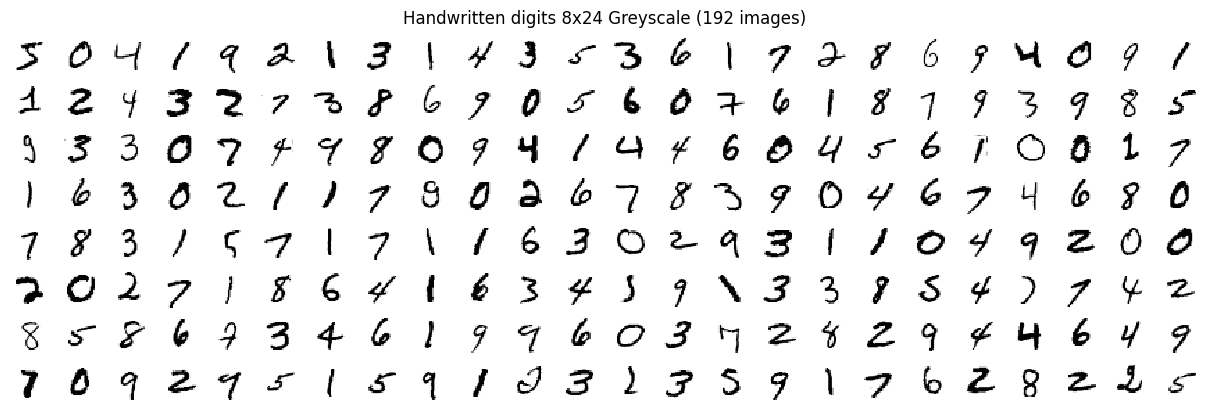

In [10]:
wsize = 24
hsize = 8
fig, axes = plt.subplots(hsize,wsize,figsize=(wsize/2,hsize/2),layout="constrained")

c = 0
for i in range(hsize):
    for j in range(wsize):
        axes[i][j].imshow(train_X[c].reshape((28,28)), interpolation='none', cmap=cm.Greys)
        axes[i][j].axis('off')
        c += 1
plt.suptitle(f"Handwritten digits {hsize}x{wsize} Greyscale ({wsize*hsize} images)")
plt.show()

In [11]:
def feature_scale(data_unscaled, scaled=True):
    if scaled == False:
        return data_unscaled

    max_value = np.max(data_unscaled)

    data_scaled = np.array(data_unscaled)
    data_scaled = data_scaled / max_value
    # min max normalization
    
    return data_scaled

train_X = feature_scale(train_X, scaled=True) # feature scale the training set
test_X = feature_scale(test_X, scaled=True) # feature scale the test set

Here, we just scale both the training set and the test set just like last time. We also need to reshape the features to match what we expect.

In [12]:
train_size = train_X.shape[0]
test_size = test_X.shape[0]
train_X = train_X.reshape((train_size,-1)) # reshape the training set
test_X = test_X.reshape((test_size,-1)) # reshape the test set
print("TrainX:",train_X.shape)
print("TestX:",test_X.shape)

TrainX: (60000, 784)
TestX: (10000, 784)


In [13]:
def get_prediction_categories(probabilities):
    return np.argmax(probabilities,axis=1)

Last time, we did mnist using logistic regression and managed to achieve 92% with scikit (90% on our custom model). Here, the goal is to use feature engineering to get a better accuracy on mnist. 92% is good but im disappointed. I want higher accuracy. Therefore, I'm trying to feature engineer and help the model learn better. One idea is to use convolutions and edge detection filters as the features.

In [14]:
# setup for convolution
gx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
gy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
print(gx.shape, gy.shape)

(3, 3) (3, 3)


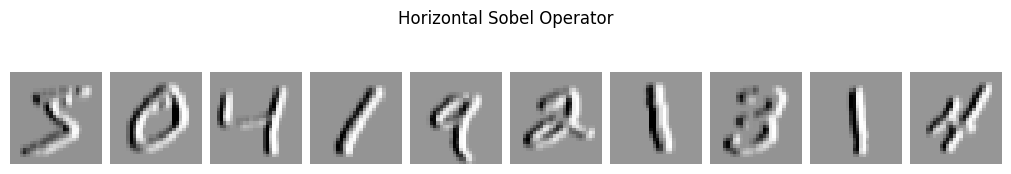

In [15]:
fig, axes = plt.subplots(1,10,figsize=(10,2),layout="constrained")

for i in range(10):
        g = convolve2d(train_X[i].reshape((28,28)), gx, mode='same')
        axes[i].imshow(g, interpolation='none', cmap=cm.Greys)
        axes[i].axis('off')
plt.suptitle(f"Horizontal Sobel Operator")
plt.show()

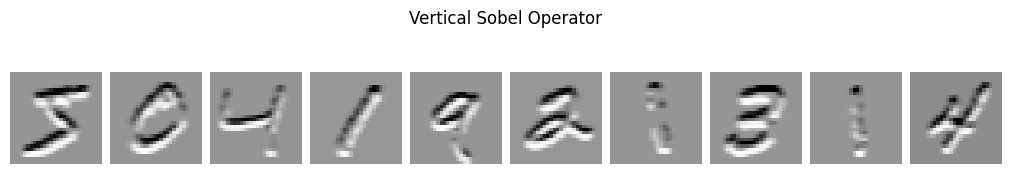

In [16]:
fig, axes = plt.subplots(1,10,figsize=(10,2),layout="constrained")

for i in range(10):
        g = convolve2d(train_X[i].reshape((28,28)), gy, mode='same')
        axes[i].imshow(g, interpolation='none', cmap=cm.Greys)
        axes[i].axis('off')
plt.suptitle(f"Vertical Sobel Operator")
plt.show()

There are 2 separate kernels (matrices), one for vertical edge detection and another for horizontal edge detection. I showcased how the images look like after I did the operation on them. 

In [17]:
horizontal_convolutions = np.empty((train_samples,784))
vertical_convolutions = np.empty((train_samples,784))
for i in range(train_samples):
    conv2d_hor = convolve2d(train_X[i].reshape((28,28)), gx, mode='same')
    conv2d_ver = convolve2d(train_X[i].reshape((28,28)), gy, mode='same')
    horizontal_convolutions[i] = conv2d_hor.reshape((-1))
    vertical_convolutions[i] = conv2d_ver.reshape((-1))
train_X_features = np.hstack([train_X, horizontal_convolutions, vertical_convolutions])
print(train_X_features.shape)

(60000, 2352)


This code above calculates the convolutions for all images in the dataset and adds the new features to them.

In [18]:
model = LogisticRegression()
model.fit(train_X_features, train_y)

C:\Users\abhin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [19]:
horizontal_convolutions = np.empty((test_samples,784))
vertical_convolutions = np.empty((test_samples,784))
for i in range(test_samples):
    conv2d_hor = convolve2d(test_X[i].reshape((28,28)), gx, mode='same')
    conv2d_ver = convolve2d(test_X[i].reshape((28,28)), gy, mode='same')
    horizontal_convolutions[i] = conv2d_hor.reshape((-1))
    vertical_convolutions[i] = conv2d_ver.reshape((-1))
test_X_features = np.hstack([test_X, horizontal_convolutions, vertical_convolutions])
print(test_X_features.shape)

(10000, 2352)


In [20]:
y_test_scikit = model.predict(test_X_features)
score_percentage = accuracy_score(test_y, y_test_scikit) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(test_y, y_test_scikit, normalize=False))
print("Misclassifications:",test_samples - misclassifications)

Accuracy: 92.68 %
Misclassifications: 732


Accuracy did improve but barely (~0.1 %). Looks like the convolutions didn't really help much. The main issue is that the model won't understand how different features are connected together. After all, features are just pixels at the end of the day and since the features are separate, it's like we randomized the image pixels and are feeding the model just that. The model will struggle to understand that different features actually are connected to each other. So a distance metric must be used. For this reason, using hog features instead will help solve the connectiveness issue by taking into account the distances for these pixels. 

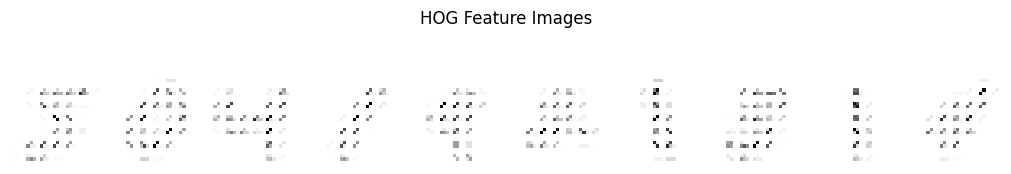

In [26]:
fig, axes = plt.subplots(1,10,figsize=(10,2),layout="constrained")

for i in range(10):
        _, hog_feature = hog(train_X[i].reshape((28,28)), pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
        axes[i].imshow(hog_feature, interpolation='none', cmap=cm.Greys)
        axes[i].axis('off')
plt.suptitle(f"HOG Feature Images")
plt.show()

These are the hog features for the first 10 images. It removes a lot of unnecessary pixels that are unnecessary for correct classification. 

In [22]:
hog_features = np.empty((train_samples,784))

for i in range(train_samples):
    _, hfeature = hog(train_X[i].reshape((28,28)), pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
    hog_features[i] = hfeature.reshape((-1))
train_X_features = np.hstack([train_X, hog_features])
print(train_X_features.shape)

(60000, 1568)


In [23]:
hog_features = np.empty((test_samples,784))

for i in range(test_samples):
    _, hfeature = hog(test_X[i].reshape((28,28)), pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)
    hog_features[i] = hfeature.reshape((-1))
test_X_features = np.hstack([test_X, hog_features])
print(test_X_features.shape)

(10000, 1568)


HOG takes a really long time to compute. But there should be a reason it's used so much in mnist.

In [24]:
model = LogisticRegression()
model.fit(train_X_features, train_y)

C:\Users\abhin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [25]:
y_test_scikit = model.predict(test_X_features)
score_percentage = accuracy_score(test_y, y_test_scikit) * 100
print("Accuracy:",round(score_percentage, 2),"%") # show accuracy till 2 decimal places
misclassifications = int(accuracy_score(test_y, y_test_scikit, normalize=False))
print("Misclassifications:",test_samples - misclassifications)

Accuracy: 96.88 %
Misclassifications: 312


Omg, this is incredible. It achieves around ~96% now compared to the 92% we were achieving last time. This is all from scikit's logistic regression too. HOG features work really well then. Initially, we tried convolutions then tried HOG. We achieved 96% with only logistic regression. This is showing that with the right features the model accuracy can improve quite considerably. 